<a href="https://colab.research.google.com/github/wqiu96/capstone20-1/blob/master/src/result_hjb_mdp_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
#import ipdb

import itertools
class Pde:
    def __init__(self, n_dim = 2):
        self.n_dim = n_dim    
        self.lam = 0.
        print('>>> n_dim: '+str(n_dim))
    drift = lambda self,s,a: a
    
    run_cost = lambda self,s,a: (
            self.n_dim + sum([s1**2 for s1 in s])*2.0 
            + sum([a1**2 for a1 in a])/2.0
            )
    
    term_cost = lambda self,s: - sum([s1**2 for s1 in s])
    exact_soln = lambda self,s: - sum([s1**2 for s1 in s])


class Mdp(Pde):
    def __init__(self, n_dim = 2, n_mesh = 8):
        super().__init__(n_dim)
        self.n_mesh= 2*n_mesh  
        self.h_mesh = 2./self.n_mesh #mesh size
        self.v_shape = tuple([self.n_mesh + 1]*self.n_dim)
        print('>>> n_mesh: '+str(self.n_mesh))


    #input: list of index
    #return: physicial coordinate
    def i2s(self,ix): 
        return [x * self.h_mesh-1 for x in ix]
    
    def is_interior(self,ix):
        return all(map(lambda a: 0<a<self.n_mesh, ix))
        
    #input: lists of index and action
    #return: discount rate, running cost, list of next index, list of probability
    def step(self, ix, a, fd='cfd'):
        #ix = list(ix)
        s = self.i2s(ix)
        b = Pde.drift(Pde, s, a)
        if fd=='cfd':
            lam = self.n_dim/(self.n_dim+self.lam*(self.h_mesh**2))
            run_cost_h = self.h_mesh**2*self.run_cost(s,a)/self.n_dim
            
            ix_next = []; pr_next= []
            #cfd
            if self.is_interior(ix):
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]+=1; ix_next += [ix1,]
                    pr1 = (1+self.h_mesh*b[i])/(self.n_dim*2.0) 
                    pr_next += [pr1,]
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]-=1; ix_next += [ix1,]
                    pr1 = (1-self.h_mesh*b[i])/(self.n_dim*2.0) 
                    pr_next += [pr1,]
        elif fd=='ufd':
            c = self.n_dim+sum([abs(b1) for b1 in b])*self.h_mesh
            b_plus = [(abs(b1)+b1)/2. for b1 in b]
            b_minus = [(abs(b1)-b1)/2. for b1 in b]
            lam = c/(c+self.h_mesh**2*self.lam)
            run_cost_h = self.h_mesh**2*self.run_cost(s,a)/c
            ix_next = []; pr_next= []
            #ufd
            if self.is_interior(ix):
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]+=1; ix_next += [ix1,]
                    pr1 = (1+2.*self.h_mesh*b_plus[i])/(c*2.0) 
                    pr_next += [pr1,]
                for i in range(self.n_dim):
                    ix1 = ix.copy(); ix1[i]-=1; ix_next += [ix1,]
                    pr1 = (1-2.*self.h_mesh*b_minus[i])/(c*2.0) 
                    pr_next += [pr1,]        
        return lam, run_cost_h, ix_next, pr_next
    

 
####################
import itertools

def deep_iter(*shape):
    iters = (range(i) for i in shape)
    return itertools.product(*iters)


#product of a list
def product(l):
    out = 1
    for x in l:
        out *= x
    return out
    

class solver_nn(Mdp):
    def __init__(self, n_dim = 2, n_mesh = 8, fd = 'ufd'):
        super().__init__(n_dim, n_mesh)
        self.fd = fd
        self.a_space = tuple([3*n_mesh+1,]*n_dim)
        self.y_max = 0
        self.y_min = -1
        self.ta = 1/(self.y_max-self.y_min)
        self.tb = -self.y_min/(self.y_max-self.y_min)

    def linear_transform(self,y):
      return self.ta*y + self.tb

    def transform_back(self,y):
      return y/self.ta - self.tb 
  
    def i2a(self, ix):
        ix = list(ix)
        return [ix1*1./self.n_mesh - 1 for ix1 in ix]
    
    #input:
        #list of index and action, method
    #return:
        #q_val assuming v is value
    def q_val(self, ix, a, fd, v):
        lam, run_cost_h, ix_next, pr_next = self.step(ix,a,fd)
        out = run_cost_h
        for ix1, pr1 in zip(ix_next, pr_next):
          if self.is_interior(ix): 
            out+=pr1*v(torch.FloatTensor(self.i2s(ix1)))
          else:
            out+=pr1*self.term_cost(self.i2s(ix))
        out *= lam
        return out
    
    #minimum over action space
    def min_a(self, fun):
        out_ind = [0,]*self.n_dim; out_val = fun(self.i2a(out_ind))
        for ix in deep_iter(*self.a_space):
            temp = fun(self.i2a(ix))
            if temp < out_val:
                #out_ind = ix;
                out_val = temp
        return out_val #,out_ind

    def bellman(self,ix, v):
        #start_time = time.time()
        s = self.i2s(ix)
        lhs = self.linear_transform(v(torch.FloatTensor(s))); rhs = 0.
        if self.is_interior(ix):            
            fun = lambda a: self.q_val(list(ix), a, self.fd,v)
            rhs = self.min_a(fun)
            rhs = self.linear_transform(rhs)
            res = (rhs - lhs)
        else:
            rhs = self.linear_transform(self.term_cost(self.i2s(ix)))
            res = (rhs - lhs)
        #end_time = time.time()
        #print(end_time - start_time)
        return res



    def solver(self,n_epoch = 500):
        ######### nn for value
        # Linear regression model
        value = nn.Sequential(
            nn.Linear(self.n_dim, 18),
            #nn.functional.gelu(),
            nn.ReLU(),
            nn.Linear(18, 18),
            nn.ReLU(),
            nn.Linear(18, 1)
        )   
        print(value)
        #loss
        def tot_loss():
            #start_time = time.time()
            out = 0.
            for ix in deep_iter(*self.v_shape):
              if self.is_interior(ix):
                out += abs(self.bellman(ix,value))
              else:
                out += abs(self.linear_transform(self.term_cost(self.i2s(ix))) - self.linear_transform(value(torch.FloatTensor(self.i2s(ix)))))
            return 10*out#/mdp.v_size_
          
        print_n = 10
        epoch_per_print= int(n_epoch/print_n)
        #lr = 1/(2*epoch+1000.)
        l = []
        start_time = time.time()
        for epoch in range(n_epoch):
            #ipdb.set_trace()
            loss = tot_loss() #forward pass
            #backward propogation
            # optimizer
            momentum = .95
            #lr = 1/((epoch+200.))
            lr = min(0.0015,1/((epoch//10+600)))
            optimizer = torch.optim.SGD(value.parameters(), lr, momentum = momentum) 
            #optimizer = torch.optim.SGD(value.parameters(), 0.0001, momentum = .8)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            if (epoch+1) % epoch_per_print == 0 or epoch == 0:
              print('Epoch [{}/{}], Loss: {:.4f}'.format(
                      epoch+1, n_epoch, loss.item()))
            if loss.item()<0.0002:
                break
        plt.plot([i for i in range(199,len(l))],l[199:])
        end_time = time.time()
        print('>>>time elapsed is: ' + str(end_time - start_time))
        return value

>>> n_dim: 1
>>> n_mesh: 16
Sequential(
  (0): Linear(in_features=1, out_features=18, bias=True)
  (1): ReLU()
  (2): Linear(in_features=18, out_features=18, bias=True)
  (3): ReLU()
  (4): Linear(in_features=18, out_features=1, bias=True)
)
Epoch [1/3000], Loss: 21.2862
Epoch [300/3000], Loss: 4.3321
Epoch [600/3000], Loss: 3.1225
Epoch [900/3000], Loss: 3.2016
Epoch [1200/3000], Loss: 1.3578
Epoch [1500/3000], Loss: 1.7680
Epoch [1800/3000], Loss: 1.5853
Epoch [2100/3000], Loss: 1.7801
Epoch [2400/3000], Loss: 2.0507
Epoch [2700/3000], Loss: 1.2954
Epoch [3000/3000], Loss: 1.0458
>>>time elapsed is: 441.1988067626953


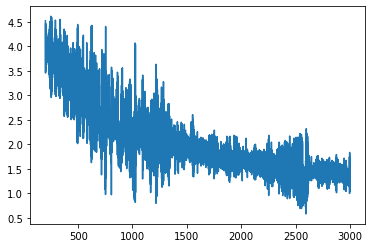

In [26]:
vi = solver_nn(n_dim=1, n_mesh=8, fd='cfd')
value = vi.solver(3000)


In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

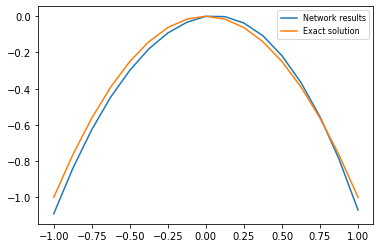

In [28]:
x = []
y = []
y1 = []
for ix_s in deep_iter(*vi.v_shape):
    s1 = vi.i2s(ix_s)
    x.append(s1)
    #v1 = v[ix_s]
    #v1 =vi.transform_back(value(torch.FloatTensor(s1)).item())
    v1 = value(torch.FloatTensor(s1)).item()
    v2 = vi.term_cost(s1)
    y.append(v1)
    y1.append(v2)
plt.plot(x,y,label = 'Network results')
plt.plot(x,y1,label = 'Exact solution')
plt.legend(loc='upper right', prop={'size':8})
plt.show()

In [29]:
print('>>>sup norm error is: ' + str(np.max(abs(np.array(y)-np.array(y1)))))

>>>sup norm error is: 0.09117889404296875


Text(0, 0.5, 'Loss')

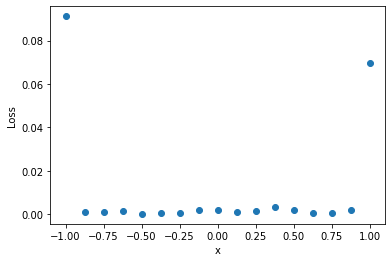

In [30]:
losss = []
for ix in deep_iter(*vi.v_shape):
  if vi.is_interior(ix):
    loss = abs(vi.bellman(ix,value))
  else:
    loss = abs(vi.linear_transform(vi.term_cost(vi.i2s(ix))) - vi.linear_transform(value(torch.FloatTensor(vi.i2s(ix)))))
  losss.append(loss.item())
plt.scatter(x,losss)
plt.xlabel('x')
plt.ylabel('Loss')